In [22]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget

sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

In [206]:
def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    import math
    earliest_time = math.inf
    for frame in dataframes:
        if frame.iloc[0]["Time"] < earliest_time:
            earliest_time = frame.iloc[0]["Time"]

    for frame in dataframes:
        frame['Time'] -= earliest_time

    return dataframes

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df_list, datacols_list, remove_identicals=True):
    np_column = np.array(["Time"] + datacols_list)
    for i in range(len(df_list)):
        if df_list[i].columns.shape == np_column.shape:
            if np.all(df_list[i].columns == np_column):
                df = df_list[i]

    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

def ret_track_df(df):
    # create an empty list to store DataFrames
    dfs = []

    # iterate over rows of the original DataFrame
    for index, row in df.iterrows():
        # split the bounding boxes string into individual boxes
        bbs = row['bbs'].replace('[','').replace(']','').split(', ')
        # create a DataFrame for each box and append it to the list of DataFrames
        for bb in bbs:
            bb_dict = {}
            for item in bb.split("\n"):
                key, value = item.split(": ")
                bb_dict[key.strip()] = float(value) if key.strip() not in ["id", "Class"] else value.strip().replace('"', '')
            new_row = {**row.to_dict(), **bb_dict}
            dfs.append(pd.DataFrame(new_row, index=[index]))

    # concatenate the list of DataFrames into a single DataFrame
    new_df = pd.concat(dfs, axis=0, ignore_index=True)

    new_df = new_df[["Time", "probability",	"xmin",	"ymin",	"xmax",	"ymax",	"id",	"Class"]]

    new_df['id'] = new_df['id'].astype(int)

    # extract the desired columns using loc
    new_df = new_df.loc[:, ['Time', 'id', 'probability', 'Class', 'xmin', 'ymin', 'xmax', 'ymax']]

    # calculate the center x and y coordinates
    new_df['center_x'] = (new_df['xmin'] + new_df['xmax']) / 2
    new_df['center_y'] = (new_df['ymin'] + new_df['ymax']) / 2

    # drop the original xmin, ymin, xmax, ymax columns
    new_df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax'], inplace=True)

    return new_df

def remove_parentheses(string):
    return string.replace('(', '').replace(')', '')

# Define a function to extract the first three elements on the diagonal
def extract_diagonal(row):
    elements = row['pose.covariance'].split(',')
    return pd.Series([float(remove_parentheses(elements[0])), float(elements[7]), float(remove_parentheses(elements[14]))])


In [179]:
gt_available = False
AT_avaiable = True
DNN_available = True
GNSS_avaiable = True
EKF_available = True
anafi_height_available = True

## Load bagfile

In [223]:
b = bagreader('/home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/test_PT/offline/test2_no_simtime/2023-03-29-15-14-00.bag')

b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/catkin_ws/src/msc_thesis/test_tools/scripts/live_rosbaging/rosbags/test_PT/offline/test2_no_simtime/2023-03-29-15-14-00.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,3440,30.926428
1,/anafi/gnss_location,sensor_msgs/NavSatFix,3440,30.582543
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,3439,30.471342
3,/anafi/gnss_ned_in_body_frame/1hz,geometry_msgs/PointStamped,112,0.984085
4,/anafi/height,anafi_uav_msgs/Float32Stamped,3440,30.555807
5,/anafi/image,sensor_msgs/Image,3439,30.698378
6,/anafi/ned_pos_from_gnss,geometry_msgs/PointStamped,3439,30.549910
7,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,3440,30.679179
8,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,568,4.996330
9,/anafi/pose,geometry_msgs/PoseStamped,3410,30.551578


## Read topics

In [224]:
if gt_available: 
    gt_anafi_pose = b.message_by_topic('/qualisys/Anafi/pose')
    df_gt_anafi_pose = pd.read_csv(gt_anafi_pose)

    df_gt_anafi_pose = drop_columns_in_df(df_gt_anafi_pose)
    df_gt_anafi_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
    df_gt_anafi_pose = rename_columns(df_gt_anafi_pose, ["anafi_x", "anafi_y", "anafi_z"])

In [225]:
if gt_available: 
    gt_platform_pose = b.message_by_topic('/qualisys/Platform/pose')
    df_gt_platform_pose = pd.read_csv(gt_platform_pose)

    df_gt_platform_pose = drop_columns_in_df(df_gt_platform_pose)
    df_gt_platform_pose.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
    df_gt_platform_pose = rename_columns(df_gt_platform_pose, ["platform_x", "platform_y", "platform_z"])

## Construct the GT platform position in body frame

In [226]:
if gt_available:
    # Load the drone orientation from the anafi
    from math import degrees


    gt_anafi_pose_NED = b.message_by_topic('/qualisys/Anafi/pose')
    df_gt_anafi_pose_NED = pd.read_csv(gt_anafi_pose)

    # Load the position of the platform
    gt_platform_pose_NED = b.message_by_topic('/qualisys/Platform/pose')
    df_gt_platform_pose_NED = pd.read_csv(gt_platform_pose)
    df_gt_platform_pose_NED = drop_columns_in_df(df_gt_platform_pose_NED)
    df_gt_platform_pose_NED.drop(columns=["pose.orientation.x", "pose.orientation.y", "pose.orientation.z", "pose.orientation.w"], inplace=True)
    df_gt_platform_pose_NED = rename_columns(df_gt_platform_pose_NED, ["platform_x", "platform_y", "platform_z"])

    # Sync the two dataframes based on timestamps
    df_gt_NED = sync_dfs_based_on_time([df_gt_anafi_pose_NED, df_gt_platform_pose_NED])

    # Create the rotation objects and apply the rotations to the pose of the platform
    df_rotation_NED_to_body = df_gt_NED[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    # rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body)

    rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body).as_euler("xyz", degrees=True)
    rotation_NED_to_body[2,:] += 0
    # np.array([np.array(rotation_NED_to_body[0,:]).T, np.array(rotation_NED_to_body[1,:]).T, np.array(rotation_NED_to_body[2,:]).T]).T
    rotation_NED_to_body= Rotation.from_euler('xyz', rotation_NED_to_body, degrees=True).inv()


    platform_pos_body = rotation_NED_to_body.apply(df_gt_NED[["platform_x", "platform_y", "platform_z"]])
    df_platform_pos_body = pd.DataFrame(platform_pos_body)
    df_platform_pos_body.columns = ["platform_x_body", "platform_y_body", "platform_z_body"]

    # Get the anafi position in the body frame
    anafi_pos_body = rotation_NED_to_body.apply(df_gt_NED[["pose.position.x", "pose.position.y", "pose.position.z"]])
    df_anafi_pos_body = pd.DataFrame(anafi_pos_body)
    df_anafi_pos_body.columns = ["anafi_x_body", "anafi_y_body", "anafi_z_body"]

    conc = [df_gt_NED, df_platform_pos_body, df_anafi_pos_body]

    df_positions_body = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_positions_body = df_positions_body[["Time", "platform_x_body", "platform_y_body", "platform_z_body", "anafi_x_body", "anafi_y_body", "anafi_z_body"]]

    df_positions_body['drone_to_platform_body_x'] = df_positions_body["platform_x_body"] - df_positions_body["anafi_x_body"]
    df_positions_body['drone_to_platform_body_y'] = df_positions_body["platform_y_body"] - df_positions_body["anafi_y_body"]
    df_positions_body['drone_to_platform_body_z'] = df_positions_body["platform_z_body"] - df_positions_body["anafi_z_body"]

In [227]:
if AT_avaiable:
    apriltag_pose = b.message_by_topic('/estimate/aprilTags/pose')
    df_apriltag_pose = pd.read_csv(apriltag_pose)

    df_apriltag_pose

    df_apriltag_pose = drop_columns_in_df(df_apriltag_pose)

    df_apriltag_pose = df_apriltag_pose[["Time", "x", "y", "z"]]

    df_apriltag_pose = rename_columns(df_apriltag_pose, ["apriltag_x", "apriltag_y", "apriltag_z"])

In [228]:
if DNN_available:
    dnn_pose = b.message_by_topic('/estimate/dnn_cv/position')
    df_dnn_pose = pd.read_csv(dnn_pose)

    df_dnn_pose = drop_columns_in_df(df_dnn_pose)

    df_dnn_pose = rename_columns(df_dnn_pose, ["dnn_x", "dnn_y", "dnn_z"])

In [229]:
if EKF_available:
    ekf_pose = b.message_by_topic('/estimate/ekf')
    df_ekf_pose = pd.read_csv(ekf_pose)

    df_ekf_pose = drop_columns_in_df(df_ekf_pose)

    # Apply the function to each row of the DataFrame and create three new columns
    df_ekf_pose[['cov_x', 'cov_y', 'cov_z']] = df_ekf_pose.apply(lambda row: extract_diagonal(row), axis=1)

    df_ekf_pose.drop(columns=['pose.covariance'], inplace=True)

    df_ekf_pose = df_ekf_pose[["Time", "pose.pose.position.x",	"pose.pose.position.y",	"pose.pose.position.z",	"cov_x",	"cov_y",	"cov_z"]]

    df_ekf_pose = rename_columns(df_ekf_pose, ["ekf_x", "ekf_y", "ekf_z"] + ['cov_x', 'cov_y', 'cov_z'])

In [230]:
if GNSS_avaiable:
    gnss_position = b.message_by_topic('/anafi/gnss_ned_in_body_frame/1hz')
    df_gnss_position = pd.read_csv(gnss_position)

    df_gnss_position = drop_columns_in_df(df_gnss_position)

    df_gnss_position = rename_columns(df_gnss_position, ["gnss_x", "gnss_y", "gnss_z"])


In [231]:
if anafi_height_available:
    anafi_height = b.message_by_topic('/anafi/height')
    df_anafi_height = pd.read_csv(anafi_height)

    df_anafi_height = drop_columns_in_df(df_anafi_height)

    df_anafi_height = rename_columns(df_anafi_height, ["anafi_z"])

In [232]:
df_list = []
    
if gt_available:
    df_list.append(df_positions_body)

if EKF_available:
    df_list.append(df_ekf_pose)

if AT_avaiable:
    df_list.append(df_apriltag_pose)

if DNN_available:
    df_list.append(df_dnn_pose)

if anafi_height_available:
    df_list.append(df_anafi_height)

if GNSS_avaiable:
    df_list.append(df_gnss_position)


df_merged_position = sync_dfs_based_on_time(df_list)

if AT_avaiable:
    apriltag_data = get_np_arr_without_nan(df_merged_position, ["apriltag_x", "apriltag_y", "apriltag_z"], remove_identicals=False)

if DNN_available:
    dnn_data = get_np_arr_without_nan(df_merged_position, ["dnn_x", "dnn_y", "dnn_z"], remove_identicals=False)

if EKF_available:
    ekf_data = get_np_arr_without_nan(df_merged_position, ["ekf_x", "ekf_y", "ekf_z", 'cov_x', 'cov_y', 'cov_z'], remove_identicals=False)

if gt_available:
    GT_data = get_np_arr_without_nan(df_merged_position, ["drone_to_platform_body_x", "drone_to_platform_body_y", "drone_to_platform_body_z"], remove_identicals=False)

if anafi_height_available:
    height_data = get_np_arr_without_nan(df_merged_position, ["anafi_z"])

if GNSS_avaiable:
    gnss_data = get_np_arr_without_nan(df_merged_position, ["gnss_x", "gnss_y", "gnss_z"], remove_identicals=False)



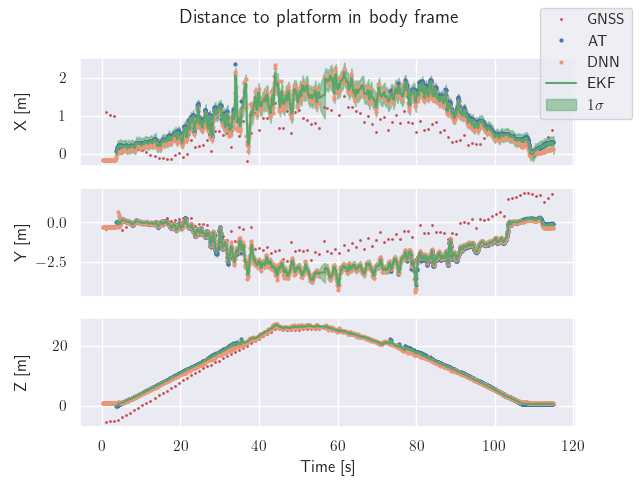

In [233]:
fig, axs = plt.subplots(3, 1)


axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])

axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)
axs[1].set_xticklabels([])

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m]')
axs[2].grid(True)


if gt_available:
    axs[0].plot(GT_data[:,0], GT_data[:,1], c='c')
    axs[1].plot(GT_data[:,0], GT_data[:,2], c='c')
    axs[2].plot(GT_data[:,0], GT_data[:,3], c='c', label="GT")

if GNSS_avaiable:
    axs[0].plot(gnss_data[:,0], gnss_data[:,1],'o', ms=1, c='r')
    axs[1].plot(gnss_data[:,0], gnss_data[:,2],'o', ms=1, c='r')
    axs[2].plot(gnss_data[:,0], gnss_data[:,3],'o', ms=1, c='r', label="GNSS")

if AT_avaiable:
    axs[0].plot(apriltag_data[:,0], apriltag_data[:,1], 'o', ms=2, c='b')
    axs[1].plot(apriltag_data[:,0], apriltag_data[:,2], 'o', ms=2, c='b')
    axs[2].plot(apriltag_data[:,0], apriltag_data[:,3], 'o', ms=2, c='b', label="AT")

if DNN_available:
    axs[0].plot(dnn_data[:,0], dnn_data[:,1], 'o', ms=2, c='darksalmon')
    axs[1].plot(dnn_data[:,0], dnn_data[:,2], 'o', ms=2, c='darksalmon')
    axs[2].plot(dnn_data[:,0], dnn_data[:,3], 'o', ms=2, c='darksalmon', label="DNN")

if EKF_available:
    axs[0].plot(ekf_data[:,0], ekf_data[:,1], c='g')
    axs[0].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,1] - np.sqrt(ekf_data[:,4]), 
                    y2=ekf_data[:,1] + np.sqrt(ekf_data[:,4]), 
                    alpha=.5, color='g')
    axs[1].plot(ekf_data[:,0], ekf_data[:,2], c='g')
    axs[1].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,2] - np.sqrt(ekf_data[:,5]), 
                    y2=ekf_data[:,2] + np.sqrt(ekf_data[:,5]), 
                    alpha=.5, color='g')
    axs[2].plot(ekf_data[:,0], ekf_data[:,3], c='g', label="EKF")
    axs[2].fill_between(ekf_data[:,0], 
                    y1=ekf_data[:,3] - np.sqrt(ekf_data[:,6]), 
                    y2=ekf_data[:,3] + np.sqrt(ekf_data[:,6]), 
                    alpha=.5, color='g', label=r"$1\sigma$")

if anafi_height_available:
    pass


handles, labels = axs[2].get_legend_handles_labels()
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Distance to platform in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()
# plt.savefig("figures_mission/all_measurements.svg")


# PRINT RMSE

In [ ]:
def make_rmse_dataframe(df, column_names_to_keep):
  df_reduced = df[column_names_to_keep]

  RMSE_df = Mask_Or_Drop_Successive_Identical_Values(df_reduced, drop=True)

  return RMSE_df


RMSE_df = make_rmse_dataframe(df_merged_position, ["drone_to_platform_body_x", "drone_to_platform_body_y", "drone_to_platform_body_z", "ekf_x", "ekf_y", "ekf_z"])

RMSE_df["x_diff"] = RMSE_df["drone_to_platform_body_x"] - RMSE_df["ekf_x"]
RMSE_df['x_diff'] = RMSE_df['x_diff'].apply(lambda x: x**2)
print("RMSE X: ", np.sqrt((RMSE_df["x_diff"]).mean()))

RMSE_df["y_diff"] = RMSE_df["drone_to_platform_body_y"] - RMSE_df["ekf_y"]
RMSE_df['y_diff'] = RMSE_df['y_diff'].apply(lambda x: x**2)
print("RMSE Y: ", np.sqrt((RMSE_df["y_diff"]).mean()))

RMSE_df["z_diff"] = RMSE_df["drone_to_platform_body_z"] - RMSE_df["ekf_z"]
RMSE_df['z_diff'] = RMSE_df['z_diff'].apply(lambda x: x**2)
print("RMSE Z: ", np.sqrt((RMSE_df["z_diff"]).mean()))

RMSE X:  0.06712159265304764
RMSE Y:  0.1079800471285787
RMSE Z:  0.05871617049413668
